# Import packages

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# Read the dataset

In [2]:
df = pd.read_csv("./dataset/final.csv")
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,Not fraud
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,Not fraud
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,Not fraud
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,Not fraud
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,Not fraud
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,...,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0,Not fraud
1852390,555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,...,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0,Not fraud
1852391,555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,...,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0,Not fraud
1852392,555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,...,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0,Not fraud


In [3]:
with open("./output/category_encoder.pkl", "rb") as file:
    category_le = pickle.load(file)
with open("./output/gender_encoder.pkl", "rb") as file:
    gender_le = pickle.load(file)
with open("./output/city_encoder.pkl", "rb") as file:
    city_le = pickle.load(file)
with open("./output/state_encoder.pkl", "rb") as file:
    state_le = pickle.load(file)
with open("./output/job_encoder.pkl", "rb") as file:
    job_le = pickle.load(file)
with open("./output/fraud_encoder.pkl", "rb") as file:
    fraud_le = pickle.load(file)

with open("./output/dtree_model.pkl", "rb") as file:
    dtree = pickle.load(file)
with open("./output/rforest_model.pkl", "rb") as file:
    rforest = pickle.load(file)
with open("./output/xgb_model.pkl", "rb") as file:
    xgb = pickle.load(file)
with open("./output/scaler.pkl", "rb") as file:
    scaler = pickle.load(file)
cnn_model = tf.keras.models.load_model("./output/cnn_model.h5")

# Data preparation

In [4]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time']).apply(lambda x: int(x.timestamp()))
df.drop(['cc_num', 'merchant', 'first', 'last', 'street', 'zip', 'trans_num', 'dob', 'unix_time', 'is_fraud', 'Unnamed: 0'], axis=1, inplace=True)
df

,trans_date_trans_time,category,amt,gender,city,state,lat,long,city_pop,job,merch_lat,merch_long,fraud
0,1546300818,misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,Not fraud
1,1546300844,grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,Not fraud
2,1546300851,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,43.150704,-112.154481,Not fraud
3,1546300876,gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,Not fraud
4,1546300986,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,Not fraud
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,1609459147,health_fitness,43.77,M,Luray,MO,40.4931,-91.8912,519,Town planner,39.946837,-91.333331,Not fraud
1852390,1609459149,kids_pets,111.84,M,Lake Jackson,TX,29.0393,-95.4401,28739,Futures trader,29.661049,-96.186633,Not fraud
1852391,1609459155,kids_pets,86.88,F,Burbank,WA,46.1966,-118.9017,3684,Musician,46.658340,-119.715054,Not fraud
1852392,1609459164,travel,7.99,M,Mesa,ID,44.6255,-116.4493,129,Cartographer,44.470525,-117.080888,Not fraud


In [5]:
feature_names = ["trans_date_trans_time", "category", "amt", "gender", "city", "state", "lat", "long", "city_pop", "job", "merch_lat", "merch_long"]

In [6]:
df['category'] = category_le.transform(df['category'])
df['gender'] = gender_le.transform(df['gender'])
df['city'] = city_le.transform(df['city'])
df['state'] = state_le.transform(df['state'])
df['job'] = job_le.transform(df['job'])
df['fraud'] = fraud_le.transform(df['fraud'])

In [7]:
X = df.drop('fraud', axis=1)
y = df['fraud']

In [8]:
def print_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Display results
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=fraud_le.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

In [9]:
def cnn_plus_model(model_name, model, X, y):
    model_pred = model.predict(X)
    print(model_name)
    print_metrics(y, model_pred)

    X_scaled = scaler.transform(X)
    X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

    y_pred_probs = cnn_model.predict(X_reshaped)
    cnn_pred = np.argmax(y_pred_probs, axis=1)
    print("CNN")
    print_metrics(y, cnn_pred)

    model_weight = 0.8
    cnn_weight = 0.2

    hybrid_predictions = np.round((model_pred * model_weight + cnn_pred * cnn_weight)).astype(int)
    print("Hybrid CNN + ", model_name)
    print_metrics(y, hybrid_predictions)

# Undersampling

In [10]:
nearMiss = NearMiss()
X_resampled, y_resampled = nearMiss.fit_resample(X, y)

# CNN + Dtree

Decision tree
Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1-Score: 0.99


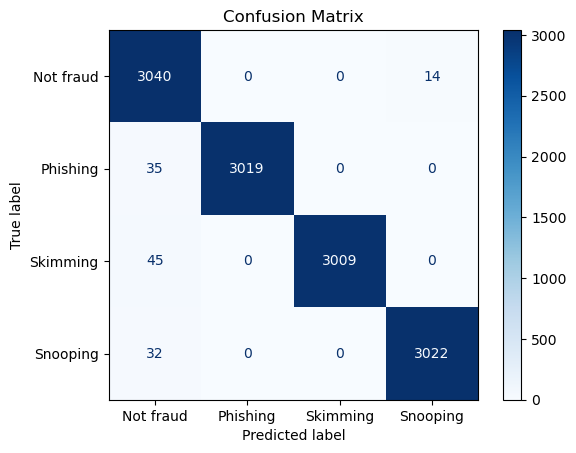

382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
CNN
Accuracy: 0.82
Precision: 0.84
Recall: 0.82
F1-Score: 0.82


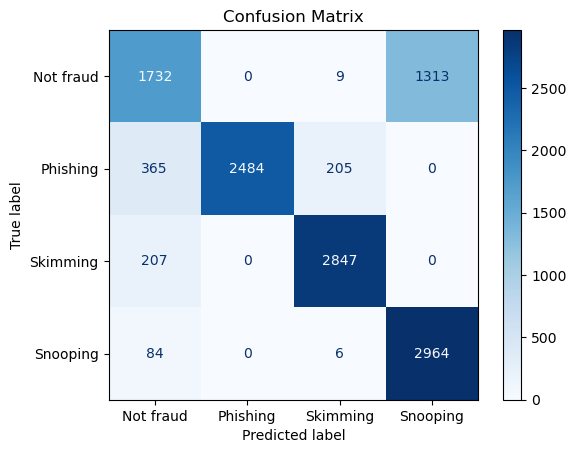

Hybrid CNN +  Decision tree
Accuracy: 0.88
Precision: 0.90
Recall: 0.88
F1-Score: 0.87


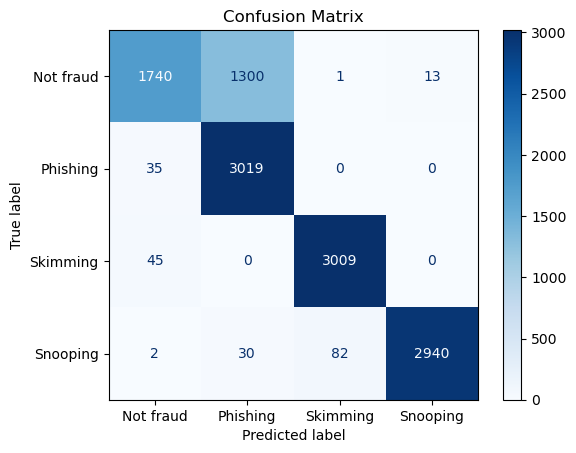

In [11]:
cnn_plus_model("Decision tree", dtree, X_resampled, y_resampled)

# CNN + XGBoost

XGBoost
Accuracy: 0.89
Precision: 0.90
Recall: 0.89
F1-Score: 0.89


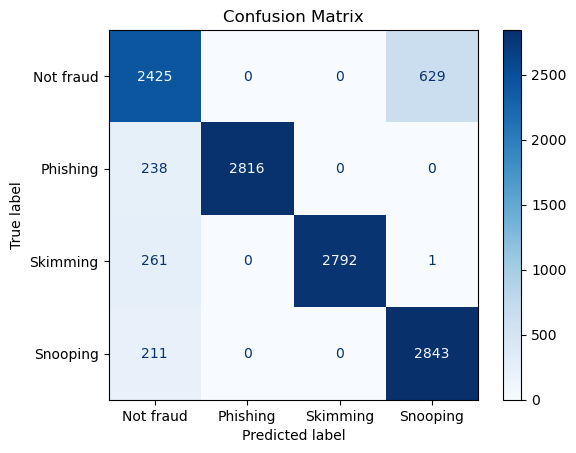

382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN
Accuracy: 0.82
Precision: 0.84
Recall: 0.82
F1-Score: 0.82


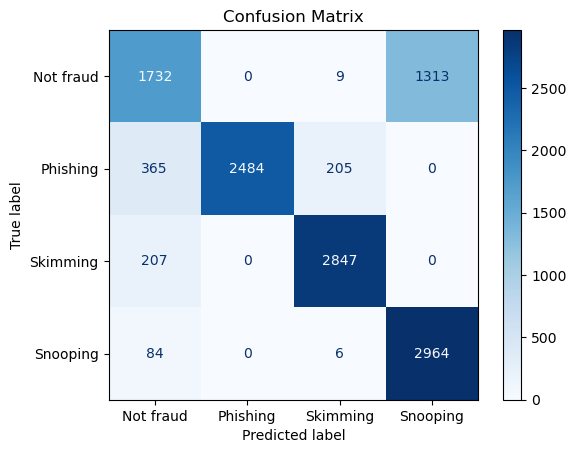

Hybrid CNN +  XGBoost
Accuracy: 0.82
Precision: 0.82
Recall: 0.82
F1-Score: 0.82


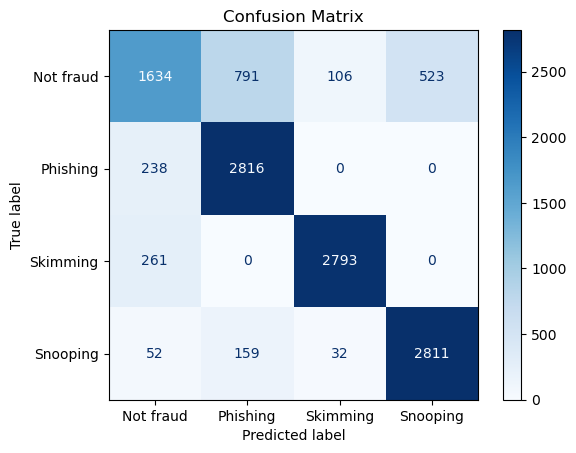

In [12]:
cnn_plus_model("XGBoost", xgb, X_resampled, y_resampled)

# Oversampling

In [13]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# CNN + Dtree

Decision tree
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00


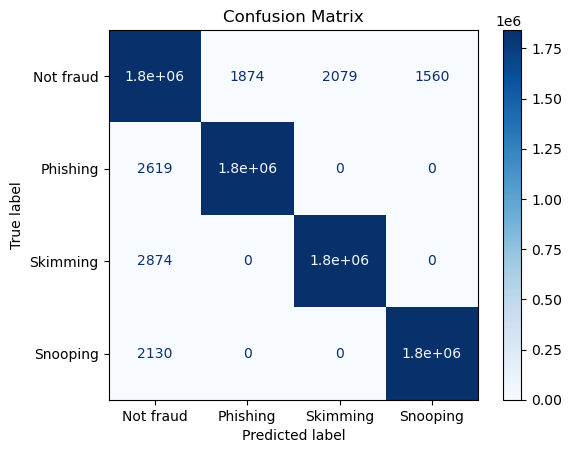

230343/230343 ━━━━━━━━━━━━━━━━━━━━ 399s 2ms/step
CNN
Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1-Score: 0.88


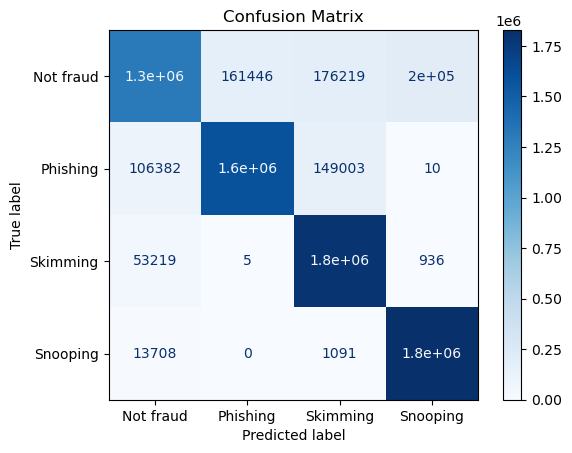

Hybrid CNN +  Decision tree
Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1-Score: 0.97


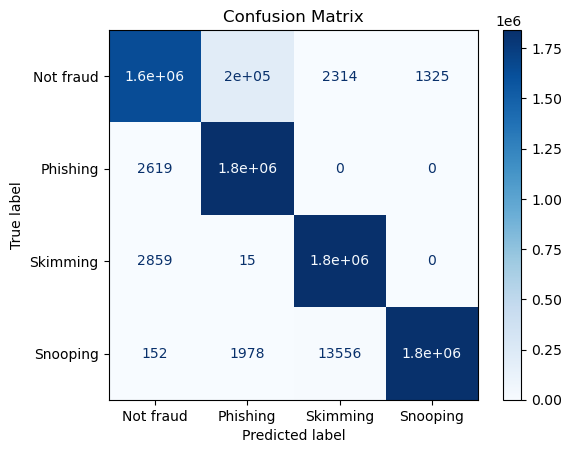

In [14]:
cnn_plus_model("Decision tree", dtree, X_resampled, y_resampled)

# CNN + XGBoost

XGBoost
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1-Score: 0.92


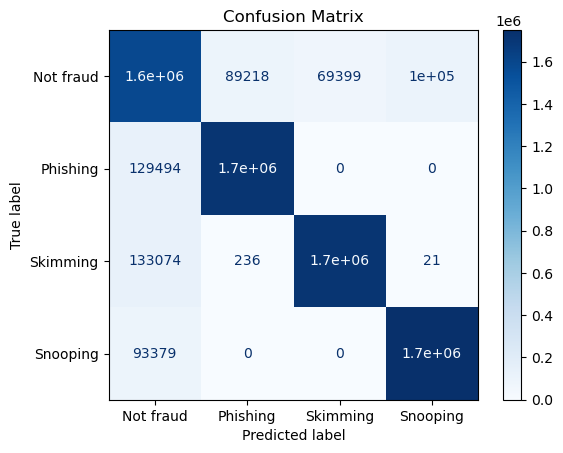

230343/230343 ━━━━━━━━━━━━━━━━━━━━ 463s 2ms/step
CNN
Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1-Score: 0.88


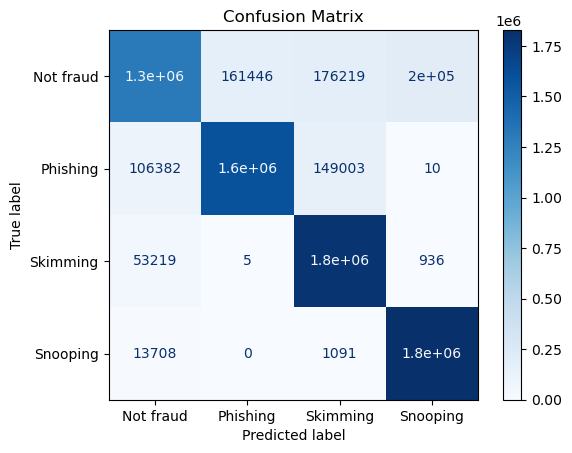

Hybrid CNN +  XGBoost
Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1-Score: 0.90


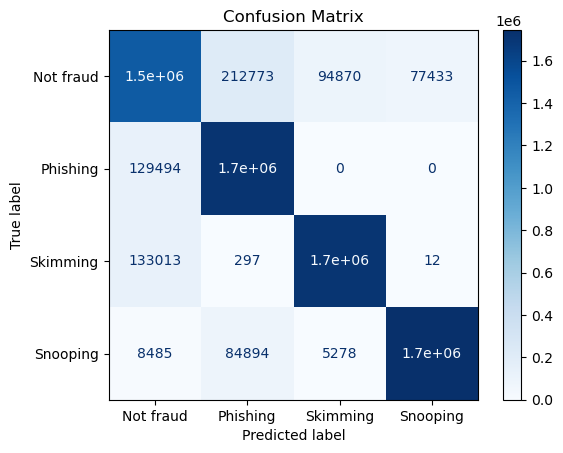

In [15]:
cnn_plus_model("XGBoost", xgb, X_resampled, y_resampled)